**1. Import the data. Analyse the dimensions of the data. Visualise the data**

In [1]:
%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:

#Importing all the necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from glob import glob 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import math

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import tensorflow as tf

from PIL import Image , ImageFilter # Image handling Library
import cv2 # Image handling Library

In [4]:
tf.__version__ #Checking tensorflow version

'2.5.0'

In [6]:
train_path = "/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train/*/*.png"
test_path = "/content/drive/MyDrive/computer vision/CNN Project/Part-1/test/*.png"
train_files = glob(train_path)
test_files = glob(test_path)

train_dir = "/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train"
test_dir = "/content/drive/MyDrive/computer vision/CNN Project/Part-1/test"
sample_submission = pd.read_csv("/content/drive/MyDrive/computer vision/CNN Project/Part-1/sample_submission.csv")

In [7]:
train_images = []
train_label = []
for img in train_files:
    train_images.append(cv2.resize(cv2.imread(img), (80,80)))
    train_label.append(img.split('/')[-2])

train_images = np.asarray(train_images)
train_label = pd.DataFrame(train_label)

print("The type of train images is:",type(train_images.shape))
print("The shape of train images is:",train_images.shape)
print("The type of train labels is:",type(train_label))
print(("The shape of train labels is:",train_label.shape))

test_images = []
test_label = []
for img1 in test_files:
    test_images.append(cv2.resize(cv2.imread(img1), (80,80)))
    test_label.append(img.split('/')[-2])
test_images = np.asarray(test_images)
test_label = pd.DataFrame(test_label)

print("The type of test images is:",type(test_images.shape))
print("The shape of test images is:",test_images.shape)
print("The type of test labels is:",type(test_label))
print(("The shape of test labels is:",test_label.shape))

The type of train images is: <class 'tuple'>
The shape of train images is: (4767, 80, 80, 3)
The type of train labels is: <class 'pandas.core.frame.DataFrame'>
('The shape of train labels is:', (4767, 1))
The type of test images is: <class 'tuple'>
The shape of test images is: (794, 80, 80, 3)
The type of test labels is: <class 'pandas.core.frame.DataFrame'>
('The shape of test labels is:', (794, 1))


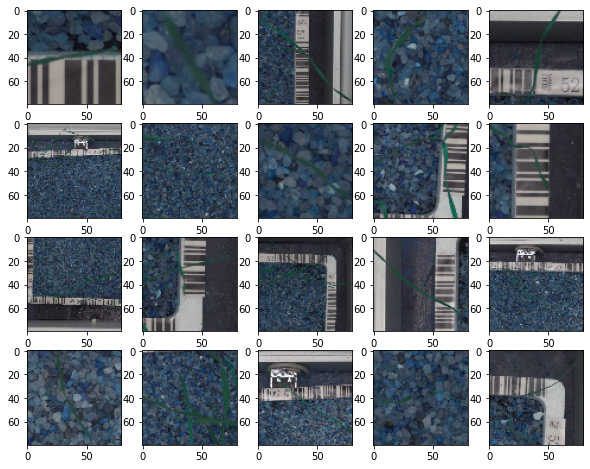

In [8]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(train_images[i])

Here we normalise the image and divide it by 255 i.e. max pixel value. It also speeds up the training

In [9]:
train_images = train_images/255
test_images = test_images/255

In [10]:
from keras.utils import np_utils
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label[0])
print("The different species of plants are: " + str(label_encoder.classes_))
encoded_train_labels = label_encoder.transform(train_label[0])

#Convert it to categorical encoders of 0s and 1s
encoded_train_labels = np_utils.to_categorical(encoded_train_labels)
num_clases = encoded_train_labels.shape[1]
print("The total plant categories are: " + str(num_clases))

The different species of plants are: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
The total plant categories are: 12


Create the training and validation splits



In [11]:
#Creating the training and validation splits:
from sklearn.model_selection import train_test_split
seed = 100
X_train, X_validation, y_train, y_validation = train_test_split(train_images, encoded_train_labels, 
                                                test_size=0.08, random_state=seed, 
                                                stratify = encoded_train_labels)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)

(4385, 80, 80, 3)
(4385, 12)
(382, 80, 80, 3)
(382, 12)


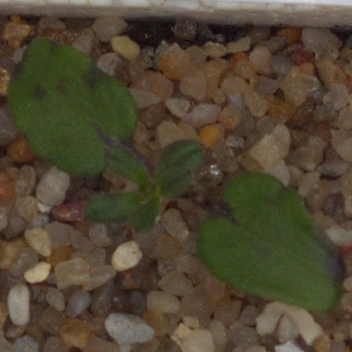

In [13]:
# Opening image for viewing
Image.open("/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train/Cleavers/0515bc601.png")

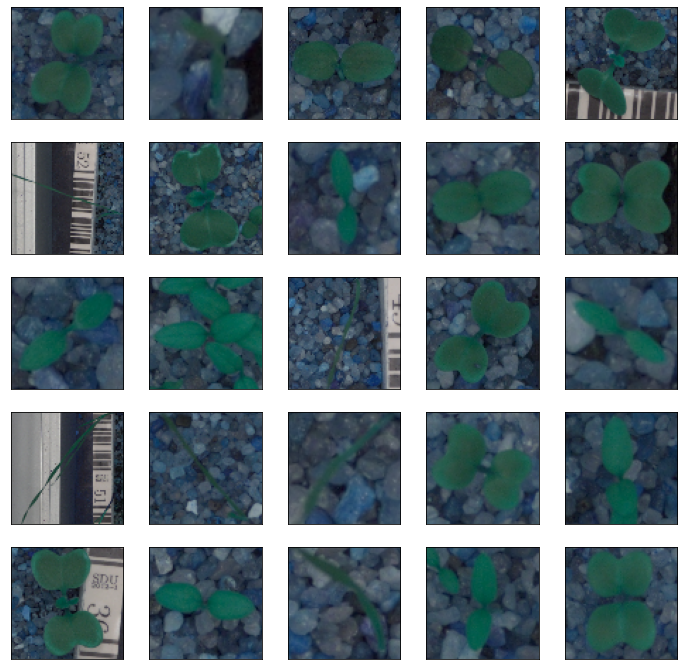

In [14]:
from random import randint
plt.figure(figsize=(12,12)) # plot 25 images
for i in range(25):
    value = randint(0,1360)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[value],cmap=plt.cm.binary)

**2. Train tune and test AIML image classifier model using:**

In [15]:
#Creating DataFrame for storing the accuracies of all different models
col_names = ['Model', 'Accuracy']
resultsdf = pd.DataFrame(columns = col_names)
print(resultsdf)

Empty DataFrame
Columns: [Model, Accuracy]
Index: []


**Use supervised learning algorithms for training.**

In [16]:
print("Actual training data shape : ", X_train.shape)
print("Actual training label shape : ", y_train.shape)

Actual training data shape :  (4385, 80, 80, 3)
Actual training label shape :  (4385, 12)


In [17]:
#Flattening the training data
nsamples, nx, ny, nz = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny*nz))

In [18]:
#Flattening the testing data
nsamples, nx, ny, nz = X_validation.shape
d2_X_test = X_validation.reshape((nsamples,nx*ny*nz))

In [19]:
print("After flattening training data shape : " ,d2_X_train.shape)
print("After flattening testing data shape : " ,d2_X_test.shape)

After flattening training data shape :  (4385, 19200)
After flattening testing data shape :  (382, 19200)


In [20]:
# Declaring MultinomialNB Classifier
clf = MultinomialNB()

In [21]:
# Training model
clf.fit(d2_X_train,(np.argmax(y_train ,axis=-1)))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [22]:
# Predicting for all of test dataset
pred = clf.predict(d2_X_test)

print("Accuracy Score of training set: {}".format(accuracy_score(np.argmax(y_train, axis=1),clf.predict(d2_X_train)))) 
print("Accuracy Score of testing set: {}".format(accuracy_score(np.argmax(y_validation, axis=1),pred)))

Accuracy Score of training set: 0.366248574686431
Accuracy Score of testing set: 0.3586387434554974


Text(0.5, 1.0, 'Accuracy Score for MultinomialNB: 0.3586387434554974')

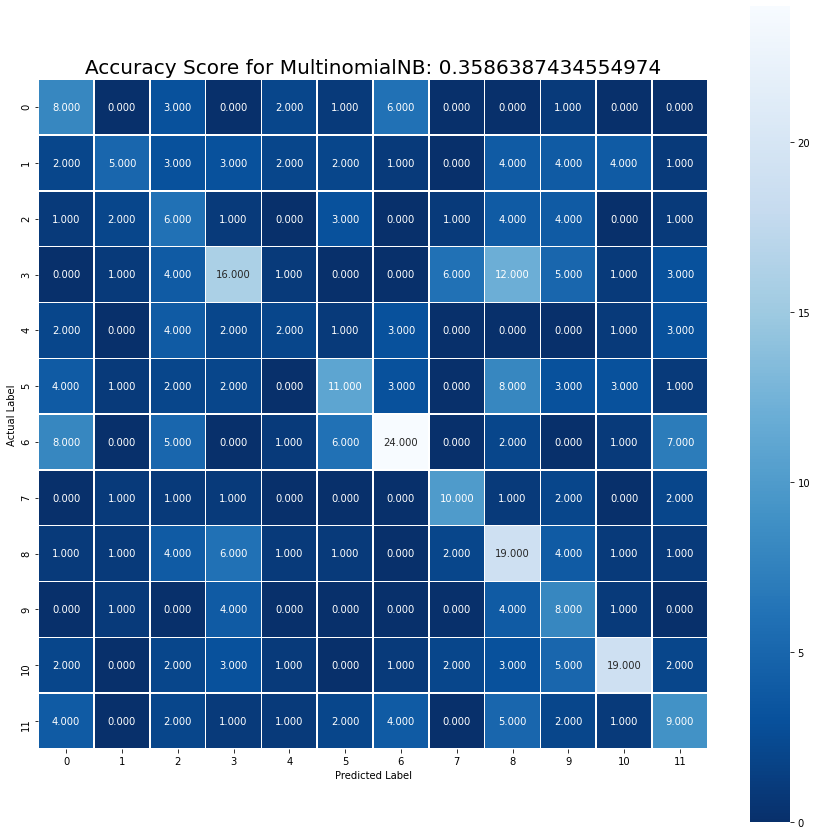

In [23]:
cm = confusion_matrix(np.argmax(y_validation, axis=1), pred)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score for MultinomialNB: {0}'.format(accuracy_score(np.argmax(y_validation, axis=1), pred))
plt.title(all_sample_title, size = 20)

In [24]:
# Classification Report
cr = classification_report(np.argmax(y_validation, axis=1),pred)
print(cr)

              precision    recall  f1-score   support

           0       0.25      0.38      0.30        21
           1       0.42      0.16      0.23        31
           2       0.17      0.26      0.20        23
           3       0.41      0.33      0.36        49
           4       0.18      0.11      0.14        18
           5       0.41      0.29      0.34        38
           6       0.57      0.44      0.50        54
           7       0.48      0.56      0.51        18
           8       0.31      0.46      0.37        41
           9       0.21      0.44      0.29        18
          10       0.59      0.47      0.53        40
          11       0.30      0.29      0.30        31

    accuracy                           0.36       382
   macro avg       0.36      0.35      0.34       382
weighted avg       0.39      0.36      0.36       382



In [25]:
# Adding Final accuracy value to Results DataFrame
tempResultsDf = pd.DataFrame({'Model':['MultinomialNB'],'Accuracy': (accuracy_score(np.argmax(y_validation, axis=1), pred))},index={'1'})
resultsdf = pd.concat([resultsdf, tempResultsDf])
resultsdf

Model  Accuracy
1  MultinomialNB  0.358639

**Using ImageDataGenerator to avoid the overfitting problem from start for ANN and CNN.**

In [26]:
#ImageDataGenerator declaration 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=50,  
                                                          width_shift_range=0.1,  
                                                          height_shift_range=0.1,  
                                                          horizontal_flip=True, 
                                                          shear_range=0.2,
                                                          zoom_range=0.2,  
                                                          fill_mode="nearest")  

# Prepare the generator
datagen.fit(X_train)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

**Use neural networks for training.**

In [27]:
ann_batch_size = 32
ann_epochs = 25
#image_size = 256

In [28]:
# Clear out tensorflow memory
tf.keras.backend.clear_session()

# Initialize Sequential model
ann = tf.keras.models.Sequential()

# Input layer 
ann.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(80,80,3)))

# Normalize the data
ann.add(tf.keras.layers.BatchNormalization())

# Dense Layer
ann.add(tf.keras.layers.Dense(128,activation='relu'))

# Normalize the data
ann.add(tf.keras.layers.BatchNormalization())

# Flatten layer
ann.add(tf.keras.layers.Flatten())

# Dense Layer
ann.add(tf.keras.layers.Dense(32,activation='relu'))

# Normalize the data
ann.add(tf.keras.layers.BatchNormalization())

#Output layer
ann.add(tf.keras.layers.Dense(12,activation='softmax'))
#ann.add(tf.keras.layers.Dense(len(datagen.classes), activation='softmax'))

#Configuring the model for training
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Model summary 
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80, 80, 64)        256       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 64)        256       
_________________________________________________________________
dense_1 (Dense)              (None, 80, 80, 128)       8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 128)       512       
_________________________________________________________________
flatten (Flatten)            (None, 819200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                26214432  
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                1

In [30]:
# Training the model
ann.fit(datagen.flow(X_train,y_train,batch_size=ann_batch_size),
                  steps_per_epoch=X_train.shape[0]/32,
                  epochs=ann_epochs,
                  validation_data=(X_validation,y_validation))

Epoch 1/25
137/137 [==============================] - 156s 1s/step - loss: 1.9636 - accuracy: 0.3804 - val_loss: 2.7365 - val_accuracy: 0.0812
Epoch 2/25
137/137 [==============================] - 155s 1s/step - loss: 1.2341 - accuracy: 0.5984 - val_loss: 3.3873 - val_accuracy: 0.0812
Epoch 3/25
137/137 [==============================] - 155s 1s/step - loss: 1.0203 - accuracy: 0.6762 - val_loss: 3.3522 - val_accuracy: 0.0497
Epoch 4/25
137/137 [==============================] - 155s 1s/step - loss: 0.8679 - accuracy: 0.7218 - val_loss: 3.3805 - val_accuracy: 0.1702
Epoch 5/25
137/137 [==============================] - 161s 1s/step - loss: 0.7974 - accuracy: 0.7414 - val_loss: 2.1779 - val_accuracy: 0.3586
Epoch 6/25
137/137 [==============================] - 158s 1s/step - loss: 0.7388 - accuracy: 0.7560 - val_loss: 0.8522 - val_accuracy: 0.6702
Epoch 7/25
137/137 [==============================] - 157s 1s/step - loss: 0.6794 - accuracy: 0.7806 - val_loss: 0.5366 - val_accuracy: 0.8298

In [31]:
# Final evaluation of the model
loss, acc = ann.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f%%' % (acc*100))
print('Train Loss: %.3f'% loss)
print()

loss, acc = ann.evaluate(X_validation, y_validation, verbose=0)
print('Test Accuracy: %.3f%%' % (acc*100))
print('Test Loss: %.3f'% loss)

Train Accuracy: 92.360%
Train Loss: 0.215

Test Accuracy: 91.099%
Test Loss: 0.254


In [32]:
# Predicting for all of test dataset 
y_pred_ann = np.argmax(ann.predict(X_validation),axis=-1)
# Label categorical Conversion
y_test_f = np.argmax(y_validation,axis=-1)

Text(0.5, 1.0, 'Accuracy Score for ANN: 0.9109947643979057')

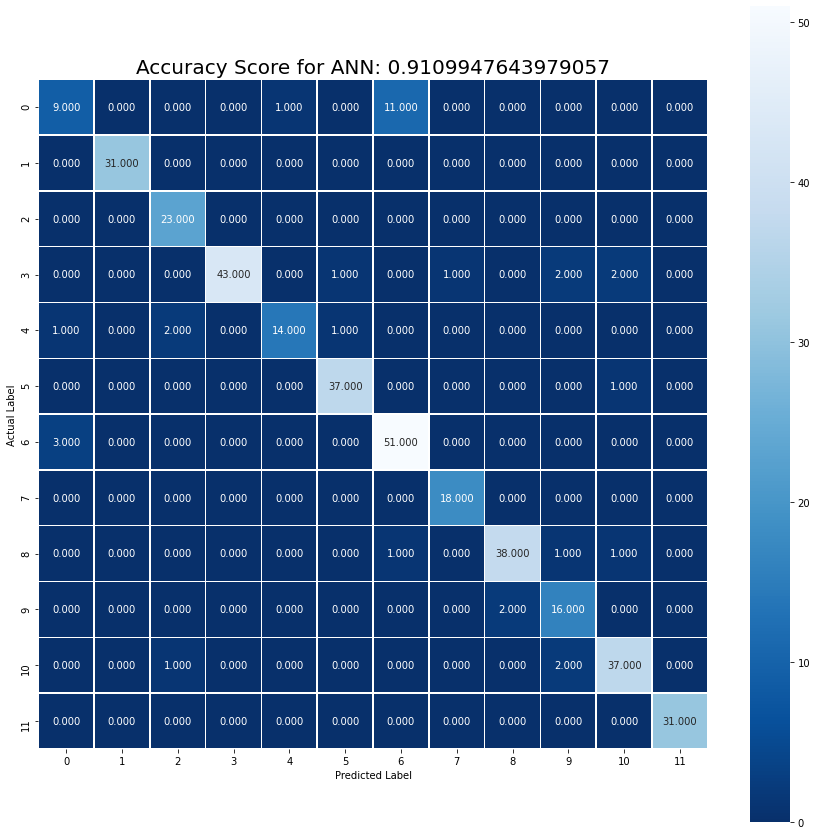

In [33]:
# Confusion Matrix

cm = confusion_matrix(y_test_f,y_pred_ann)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score for ANN: {0}'.format(accuracy_score(y_test_f,y_pred_ann))
plt.title(all_sample_title, size = 20)

In [34]:
# Adding Final accuracy value to Results DataFrame
tempResultsDf = pd.DataFrame({'Model':['ANN'],'Accuracy': ann.evaluate(X_validation, y_validation, verbose=0)[1]},index={'2'})
resultsdf = pd.concat([resultsdf, tempResultsDf])
resultsdf

Model  Accuracy
1  MultinomialNB  0.358639
2            ANN  0.910995

**Use CNN for training.**

In [35]:
cnn_batch_size = 32
cnn_epochs = 25

In [36]:
#Clear any existing model in memory
tf.keras.backend.clear_session()

#Initialize model
cnn = tf.keras.models.Sequential()

#Adding first convolutional layer
cnn.add(tf.keras.layers.Conv2D(32, #Number of filters 
                               kernel_size=(3,3), #Size of the filter
                               activation='relu',
                               input_shape=(80,80,3)))

#Add MaxPooling layer 1
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Adding second convolutional layer
cnn.add(tf.keras.layers.Conv2D(32, #Number of filters 
                               kernel_size=(3,3), #Size of the filter
                               activation='relu', padding='same'))

#Add MaxPooling layer 2
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Flatten the output
cnn.add(tf.keras.layers.Flatten())

#Dense layer 1
cnn.add(tf.keras.layers.Dense(256, activation='relu'))

#Add another dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Dense layer 2
cnn.add(tf.keras.layers.Dense(512, activation='relu'))

#Add another dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Dense layer 3
cnn.add(tf.keras.layers.Dense(1024, activation='relu')) #, kernel_regularizer = tf.keras.regularizers.l2( l=0.01)

#Add anoter dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Output layer
cnn.add(tf.keras.layers.Dense(12, activation='softmax'))

# Compile model
#adam_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
cnn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5,verbose=1, mode='auto')
callback_list = [early_stopping]

In [37]:
#Model summary 
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 39, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 19, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11552)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [38]:
#Train the model
cnn.fit(datagen.flow(X_train,y_train,batch_size=cnn_batch_size),
                    steps_per_epoch=X_train.shape[0]/32,
                    epochs=cnn_epochs,
                    validation_data=(X_validation,y_validation),
                    callbacks = callback_list)

Epoch 1/25
137/137 [==============================] - 45s 321ms/step - loss: 2.3628 - accuracy: 0.1831 - val_loss: 2.0874 - val_accuracy: 0.2827
Epoch 2/25
137/137 [==============================] - 44s 323ms/step - loss: 1.9627 - accuracy: 0.3001 - val_loss: 1.7548 - val_accuracy: 0.3848
Epoch 3/25
137/137 [==============================] - 45s 327ms/step - loss: 1.7405 - accuracy: 0.3822 - val_loss: 1.4340 - val_accuracy: 0.5052
Epoch 4/25
137/137 [==============================] - 45s 326ms/step - loss: 1.5668 - accuracy: 0.4529 - val_loss: 1.3189 - val_accuracy: 0.5497
Epoch 5/25
137/137 [==============================] - 45s 327ms/step - loss: 1.4636 - accuracy: 0.4967 - val_loss: 1.1470 - val_accuracy: 0.5838
Epoch 6/25
137/137 [==============================] - 45s 325ms/step - loss: 1.3902 - accuracy: 0.5216 - val_loss: 1.3873 - val_accuracy: 0.4764
Epoch 7/25
137/137 [==============================] - 44s 324ms/step - loss: 1.3172 - accuracy: 0.5387 - val_loss: 1.1532 - val_ac

In [39]:
# Final evaluation of the model
loss, acc = cnn.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f%%' % (acc*100))
print('Train Loss: %.3f'% loss)
print()

loss, acc = cnn.evaluate(X_validation, y_validation, verbose=0)
print('Test Accuracy: %.3f%%' % (acc*100))
print('Test Loss: %.3f'% loss)

Train Accuracy: 78.609%
Train Loss: 0.608

Test Accuracy: 82.461%
Test Loss: 0.564


In [40]:
# Predicting for all of test dataset 
y_pred_cnn = np.argmax(cnn.predict(X_validation),axis=-1)
# Label categorical Conversion
y_test_f = np.argmax(y_validation,axis=-1)

Text(0.5, 1.0, 'Accuracy Score for CNN: 0.824607329842932')

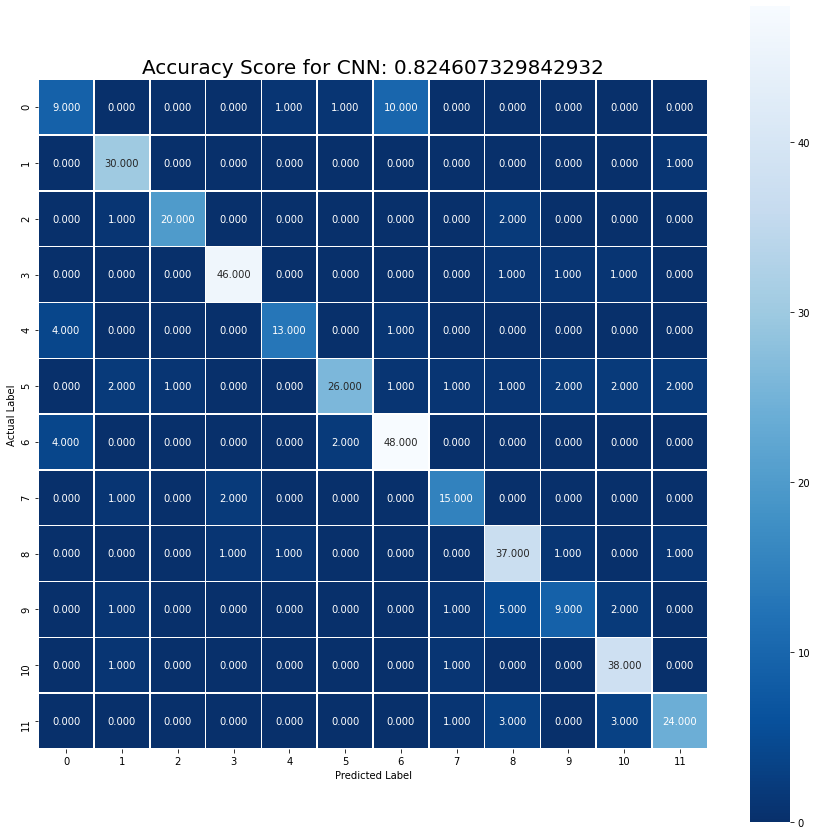

In [41]:
# Confusion Matrix

cm = confusion_matrix(y_test_f,y_pred_cnn)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score for CNN: {0}'.format(accuracy_score(y_test_f,y_pred_cnn))
plt.title(all_sample_title, size = 20)

In [42]:
# Adding Final accuracy value to Results DataFrame
tempResultsDf = pd.DataFrame({'Model':['CNN'],'Accuracy': cnn.evaluate(X_validation, y_validation, verbose=0)[1]},index={'3'})
resultsdf = pd.concat([resultsdf, tempResultsDf])
resultsdf

Model  Accuracy
1  MultinomialNB  0.358639
2            ANN  0.910995
3            CNN  0.824607

In [43]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('plant_classifier.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_acc', 
                                                    mode='max', 
                                                    verbose=1)

In [44]:
# Changing CWD to Drive for saving best model
os.chdir("/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/10Pk9PMfUOAPI3yTYZ6nvtwBA1CXRC9MG/Part-1 - Plant Seedling Classification Data'

**3. Compare the results from the above step along with your detailed observations.** 

In [45]:
resultsdf

Model  Accuracy
1  MultinomialNB  0.358639
2            ANN  0.910995
3            CNN  0.824607

**4. Pickle the best performing model**

In [46]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('plant_classifier.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_acc', 
                                                    mode='max', 
                                                    verbose=1)

**5. Import the the image in the “ Prediction” folder to predict the class. Display the image. Use the best trained image classifier model to predict the class.**

In [47]:
# Data preparation
training_set = datagen.flow_from_directory("/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train",
                                                 target_size = (80, 80),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

# Setting testing data generator's source directory
test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/Seedling - Prediction",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')


cnn.fit(training_set,
                         steps_per_epoch = int(1098/32),
                         epochs = 1,
                         validation_data = test_set,
                         validation_steps = int(272/32))

Found 4767 images belonging to 12 classes.
Found 0 images belonging to 0 classes.
34/34 [==============================] - 30s 888ms/step - loss: 377.5342 - accuracy: 0.2675


(578, 578, 3)
(80, 80, 3)
After expand_dims: (1, 80, 80, 3)
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
[0.00052958 0.00249779 0.00101245 0.20366575 0.00042146 0.05010635
 0.00132962 0.2690551  0.01194489 0.37882134 0.06480263 0.01581305]
Shepherds Purse


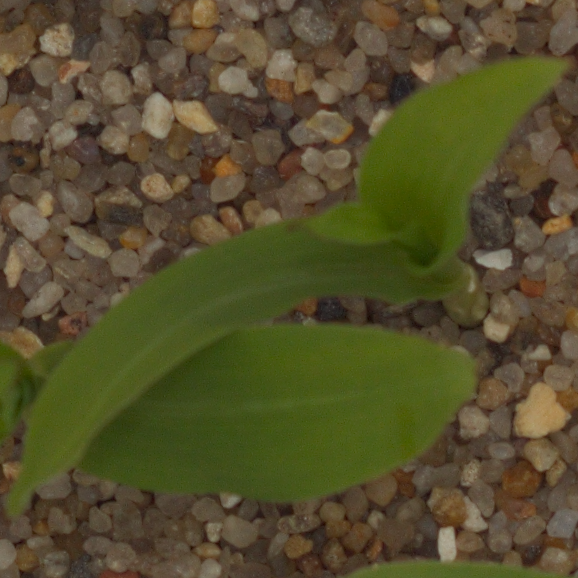

In [49]:
from PIL import Image , ImageFilter # Image handling Library
import cv2 # Image handling Library
test_image = cv2.imread("/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/Seedling - Prediction/Predict.png")


# Check if the size of the Image array is compatible with Keras model
print(test_image.shape)

# Reshape the image to 64x64x3
test_image = cv2.resize(test_image, (80, 80))
print(test_image.shape)

# If not compatible expand the dimensions to match with the Keras Input
test_image = np.expand_dims(test_image, axis = 0)
test_image =test_image*1/255.0

#Check the size of the Image array again
print('After expand_dims: '+ str(test_image.shape))


#Predict the result of the test image
result = cnn.predict(test_image)

# Check the indices Image Data Generator has allotted to each folder
classes_dict = training_set.class_indices
print(classes_dict)

# Creating a list of classes in test set for showing the result as the folder name
prediction_class = []
for class_name,index in classes_dict.items():
  prediction_class.append(class_name)
  
print(result[0])

# Index of the class with maximum probability
predicted_index = np.argmax(result[0])

# Print the name of the class
print(prediction_class[predicted_index])
Image.open("/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/Seedling - Prediction/Predict.png")

**Conclusion**

We have built a **CNN-model** to predict the class of a plant, which works quite well. (Increasing **number of epochs** and/or **adding layers** to a model can even increase the performance.

**CNN + Maxpooling + Global pooling + Dense** is a good combination for image classification.

**Inferences:-**

**1. MultinomialNB or the supervised algorithm gives the least score among other models here. As supervised learning models can't calculate the distances in 3D space or can't extract the features from images. That is why the data is to be flattened before feeding to model.**

**2. Since there is always a chance for overfitting in ANN and CNN, ImageDataGenerator was introduced earlier.**

**3. In ANN or Deep Neural Nets is better than supervised learning as its good at extracting features which helps in improving the accuracy. But the major drawback is that it has large number of weights as each layer gets added, which becomes computationally intensive and dense layer losses neighbourhood information is lost. Overfitting is observed even though accuracy is not that high.**

**4. CNN has better accuracy than ANN as it has special layer "Conv2D" which particularly helps in extracting feature from images, which then is flattened and given to a dense or Fully connected layer for output.Since dataset was small also the Dense layer losses neighbourhood information is lost, so the accuracy could'nt be improved much. Model is good but accuracy is on mid level.**

**5. This is where transfer learning comes into picture as this pretrained model has been trained on a very large dataset which helps in getting bettter accuracy.**

## **PART 2**

**Explain in depth why CNN out performs neural networks which in turn out perform supervised learning models when it comes to image classification. Use the markdown option in Jupiter for your answer**

* Neural Networks (NN), or more precisely Artificial Neural Networks (ANN), is a class of Machine Learning algorithms that recently received a lot of attention (again!) due to the availability of Big Data and fast computing facilities (most of Deep Learning algorithms are essentially different variations of ANN).

* The class of ANN covers several architectures including Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN) eg LSTM and GRU, Autoencoders, and Deep Belief Networks. Therefore, CNN is just one kind of ANN.

* Generally speaking, an ANN is a collection of connected and tunable units (a.k.a. nodes, neurons, and artificial neurons) which can pass a signal (usually a real-valued number) from a unit to another. The number of (layers of) units, their types, and the way they are connected to each other is called the network architecture.

* A CNN, in specific, has one or more layers of convolution units. A convolution unit receives its input from multiple units from the previous layer which together create a proximity. Therefore, the input units (that form a small neighborhood) share their weights.

**The convolution units (as well as pooling units) are especially beneficial as:**

  * They reduce the number of units in the network (since they are many-to-one mappings). This means, there are fewer parameters to learn which reduces the chance of overfitting as the model would be less complex than a fully connected network. They consider the context/shared information in the small neighborhoods. This future is very important in many applications such as image, video, text, and speech processing/mining as the neighboring inputs (eg pixels, frames, words, etc) usually carry related information.

  * Also from our outputs we can see the that CNN outperformed NN with a very wide gap of accuracy.

* The reason why Convolutional Neural Networks (CNNs) do so much better than classic neural networks on images and videos is that the convolutional layers take advantage of inherent properties of images.

**Convolutions**

* Simple feedforward neural networks don’t see any order in their inputs. If you shuffle all your images in the same way, the neural network would have the very same performance it has when trained on images that are not shuffled.

* CNN, in opposition, take advantage of local spatial coherence of images. This means that they are able to reduce dramatically the number of operation needed to process an image by using convolution on patches of adjacent pixels, because adjacent pixels together are meaningful. We also call that local connectivity. Each map is then filled with the result of the convolution of a small patch of pixels, slid with a window over the whole image.

**Pooling layers**

* There are also the pooling layers, which downscale the image. This is possible because we retain throughout the network, features that are organized spatially like an image, and thus downscaling them makes sense as reducing the size of the image. On classic inputs you cannot downscale a vector, as there is no coherence between an input and the one next to it.

**CNNs have the following properties**:
* It is **translation invariant** — the exact location of the pixel is irrelevant for the filter.
* It is less likely to overfit — the typical number of parameters in a CNN is much smaller than that of a DNN.
* Gives us a better understanding of the model — we can look at the filters’ weights and visualize what the network “learned”.
* **Hierarchical nature** — learns patterns in by describing complex patterns using simpler ones.

* CNNs are used for image classification and recognition because of its high accuracy. The CNN follows a **hierarchical model** which works on building a network, like a funnel, and finally gives out a fully-connected layer where all the neurons are connected to each other and the output is processed.